In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import cv2
from skimage.morphology import erosion
import matplotlib.pyplot as plt
from .utils import partialDerivative, search, drawcircle

ImportError: attempted relative import with no known parent package

In [9]:
img = cv2.imread('images.jfif')

In [10]:
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [11]:
#plt.imshow(img)

In [12]:
print(img)

[[[ 64  64  64]
  [ 77  77  77]
  [ 75  75  75]
  ...
  [ 11  11  11]
  [ 11  11  11]
  [ 12  12  12]]

 [[ 66  66  66]
  [ 65  65  65]
  [ 76  76  76]
  ...
  [  7   7   7]
  [  7   7   7]
  [  8   8   8]]

 [[105 105 105]
  [ 70  70  70]
  [ 80  80  80]
  ...
  [  7   7   7]
  [  7   7   7]
  [  7   7   7]]

 ...

 [[ 79  79  79]
  [ 86  86  86]
  [ 87  87  87]
  ...
  [ 44  44  44]
  [ 49  49  49]
  [ 63  63  63]]

 [[ 91  91  91]
  [ 94  94  94]
  [ 91  91  91]
  ...
  [ 50  50  50]
  [ 48  48  48]
  [ 59  59  59]]

 [[ 96  96  96]
  [ 91  91  91]
  [100 100 100]
  ...
  [ 57  57  57]
  [ 56  56  56]
  [ 55  55  55]]]


In [13]:
#import cv2
#import numpy as np
import itertools
import math
from typing import Tuple, List


def daugman(gray_img: np.ndarray, center: Tuple[int, int],
            start_r: int, end_r: int, step: int = 1) -> Tuple[float, int]:
    """ The function will calculate pixel intensities for the circles
        in the ``range(start_r, end_r, step)`` for a given ``center``,
        and find a circle that precedes the biggest intensity drop

        :param gray_img: grayscale picture
        :param center:  center coordinates ``(x, y)``
        :param start_r: bottom value for iris radius in pixels
        :param end_r: top value for iris radius in pixels
        :param step: step value for iris radii range in pixels

        .. attention::
            Input grayscale image should be a square, not a rectangle

        :return: intensity_value, radius
    """
    x, y = center
    intensities = []
    mask = np.zeros_like(gray_img)

    # for every radius in range
    radii = list(range(start_r, end_r, step))  # type: List[int]
    for r in radii:
        # draw circle on mask
        cv2.circle(mask, center, r, 255, 1)
        # get pixel from original image, it is faster than np or cv2
        diff = gray_img & mask
        # normalize, np.add.reduce faster than .sum()
        #            diff[diff > 0] faster than .flatten()
        intensities.append(np.add.reduce(diff[diff > 0]) / (2 * math.pi * r))
        # refresh mask
        mask.fill(0)

    # calculate delta of radius intensitiveness
    #     mypy does not tolerate var type reload
    intensities_np = np.array(intensities, dtype=np.float32)
    del intensities

    # circles intensity differences, x5 faster than np.diff()
    intensities_np = intensities_np[:-1] - intensities_np[1:]
    # aply gaussian filter
    #     GaussianBlur() faster than filter2D() with custom kernel
    # original kernel:
    # > The Gaussian filter in our case is designedin MATLAB and
    # > is a 1 by 5 (rows by columns) vector with intensity values
    # > given by vector A = [0.0003 0.1065 0.7866 0.1065 0.0003]
    intensities_np = abs(cv2.GaussianBlur(intensities_np, (1, 5), 0))
    # get maximum value
    idx = np.argmax(intensities_np)  # type: int

    # return intensity value, radius
    return intensities_np[idx], radii[idx]


def find_iris(gray: np.ndarray, *,
              daugman_start: int, daugman_end: int,
              daugman_step: int = 1, points_step: int = 1,) -> Tuple[Tuple[int, int], int]:
    """ The function will apply :func:`daugman` on every pixel in the calculated image slice.
        Basically, we are calculating where lies set of valid circle centers.
        It is assumed that iris center lies within central 1/3 of the image.

        :param gray: graysacale **square** image
        :param points_step: it will run daugman for each ``points_step``th point.
                            It has linear correlation with overall iris search speed
        :param daugman_start: bottom value for iris radius in pixels for :func:``daugman``
        :param daugman_end: top value for iris radius in pixels for :func:``daugman``
        :param daugman_step: step value for iris radii range in pixels for :func:``daugman``.
                             It has linear correlation with overall iris search speed

        :return: radius with biggest intensiveness delta on image as ``((xc, yc), radius)``
    """
    h, w = gray.shape
    if h != w:
        print('Your image is not a square!')

    # reduce step for better accuracy
    # we will look only on dots within central 1/3 of image
    single_axis_range = range(int(h / 3), h - int(h / 3), points_step)
    all_points = itertools.product(single_axis_range, single_axis_range)

    intensity_values = []
    coords = []  # List[Tuple[Tuple(int, int), int]]

    for point in all_points:
        val, r = daugman(gray, point, daugman_start, daugman_end, daugman_step)
        intensity_values.append(val)
        coords.append((point, r))

    # return the radius with biggest intensiveness delta on image
    # ((xc, yc), radius)
    # x10 faster than coords[np.argmax(values)]
    best_idx = intensity_values.index(max(intensity_values))
    return coords[best_idx]

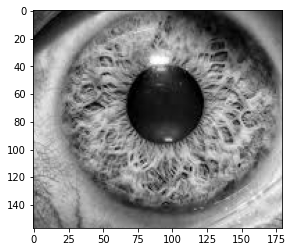

In [14]:
img = img[20:284, 20:200]
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

_ = plt.imshow(gray_img, cmap='gray')

In [15]:
answer = find_iris(gray_img, daugman_start=20, daugman_end=180, daugman_step=1, points_step=3)
print(answer)

iris_center, iris_rad = answer

Your image is not a square!
((94, 67), 29)


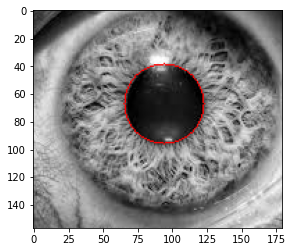

In [16]:
# plot result
out = img.copy()
cv2.circle(out, iris_center, iris_rad, (0, 0, 255), 1)
_ = plt.imshow(out[::,::,::-1])

In [ ]:
y=67
x=94
iris_image = img[y-h:y+h,x-w:x+w]
    iris_image_to_show = cv2.resize(iris_image, (iris_image.shape[1]*2, iris_image.shape[0]*2))

In [17]:
hh, ww = img.shape[: 2]
hh2 = hh // 2
ww2 = ww // 2
xc = hh // 2
yc = ww // 2


In [18]:
# given x,y are circle center and r is radius
#rectX = (67 - 29) 
#rectY = (94 - 29)
#cropp_img = img[94:(94+2*29), 67:(67+2*29)]
mask1 = np.zeros_like(img)
mask1 = cv2.circle(mask1, (xc, yc), 29, (255, 255, 255), -1)
mask2 = np.zeros_like(img)
mask2 = cv2.circle(mask2, (xc, yc), 40, (255, 255, 255), -1)

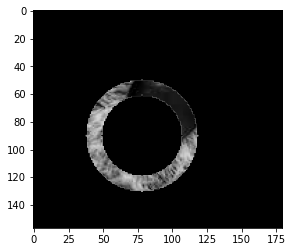

In [19]:
mask = cv2.subtract(mask2, mask1)
result = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
result[: ,: , 3] = mask[: ,: , 0]

# save results
cv2.imwrite('lena_mask1.png', mask1)
cv2.imwrite('lena_mask2.png', mask2)
cv2.imwrite('lena_masks.png', mask)
cv2.imwrite('lena_circle_masks.png', result)

plt.imshow(img)
plt.imshow(mask1)
plt.imshow(mask2)
plt.imshow(mask)
plt.imshow(result)

In [20]:
margin = 0.9 # Cut off the outer 10% of the image
polar_img = cv2.warpPolar(result, (11, 1024), (result.shape[0]/2,result.shape[1]/2), result.shape[1]*margin*0.5, cv2.WARP_POLAR_LINEAR)
# Rotate it sideways to be more visually pleasing
polar_img = cv2.rotate(polar_img, cv2.ROTATE_90_COUNTERCLOCKWISE)

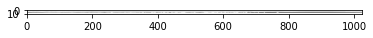

(<matplotlib.image.AxesImage at 0x1a2e09c1cc0>, None)

In [21]:
plt.imshow(polar_img),plt.show()


In [22]:
print(polar_img)

[[[225 225 225   0]
  [225 225 225   0]
  [211 211 211   0]
  ...
  [209 209 209   0]
  [209 209 209   0]
  [225 225 225   0]]

 [[143 143 143   0]
  [143 143 143   0]
  [182 182 182   0]
  ...
  [113 113 113   0]
  [113 113 113   0]
  [143 143 143   0]]

 [[136 136 136   0]
  [136 136 136   0]
  [175 175 175   0]
  ...
  [153 153 153   0]
  [153 153 153   0]
  [136 136 136   0]]

 ...

 [[ 65  65  65   0]
  [ 65  65  65   0]
  [ 65  65  65   0]
  ...
  [ 65  65  65   0]
  [ 65  65  65   0]
  [ 65  65  65   0]]

 [[ 39  39  39   0]
  [ 39  39  39   0]
  [ 39  39  39   0]
  ...
  [ 39  39  39   0]
  [ 39  39  39   0]
  [ 39  39  39   0]]

 [[ 26  26  26   0]
  [ 26  26  26   0]
  [ 26  26  26   0]
  ...
  [ 26  26  26   0]
  [ 26  26  26   0]
  [ 26  26  26   0]]]


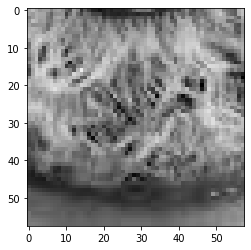

In [248]:
plt.imshow(cropp_img)

In [249]:
answ = find_iris(gray_img, daugman_start=50, daugman_end=180, daugman_step=1, points_step=2)
print(answ)
iris_center, iris_rad = answ

Your image is not a square!
((72, 78), 80)


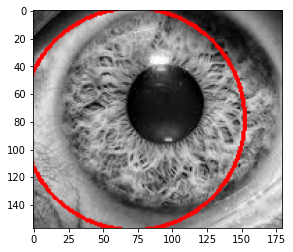

In [250]:
# plot result
out = img.copy()
cv2.circle(out, iris_center, iris_rad, (0, 0, 255), 2)
_ = plt.imshow(out[::,::,::-1])

In [251]:
rectX = (72 - 40) 
rectY = (78 - 40)
crop_img = img[72:(72+2*40), 72:(72+2*40)]

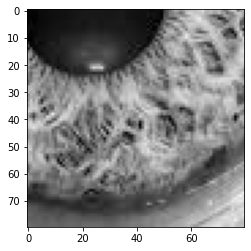

In [252]:
plt.imshow(crop_img)